# Traditional Object Detection using classifier model 

In this part, we will use pretrained ResNet50 as object classifier model. Along with it, we will use image pyramid and sliding window to buid an Object detection model. One thing we should remember is that this model will not be trainable as ResNet is already trained and the other practices don't require training.


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob


In [2]:
# Let us first create a function for applying Image Pyramid

def image_pyramid(image, scale, min_size):
    yield image
    
    while True:
        
        assert scale != 0
        # Compute the width of the next image.
        width = int(image.shape[0]/scale)
        image = cv2.resize(image, (width, width))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image 

In [3]:
# Now let us create a sliding window function 

def sliding_window(image, step, size):
    
    for y in range(0,image.shape[0]-size[1],step):
        for x in range(0,image.shape[1]-size[0],step):
            yield (x,y, image[y:y+size[1],x:x+size[0]])

Our original image is 


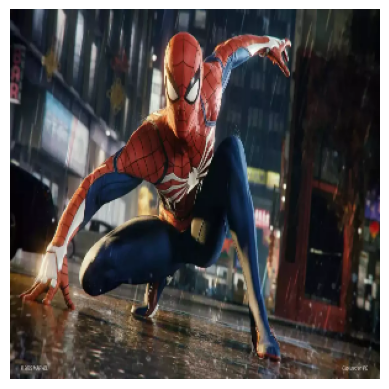

/tmp/ipykernel_40850/1778745594.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


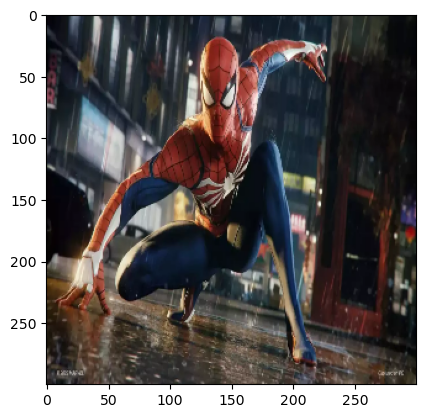

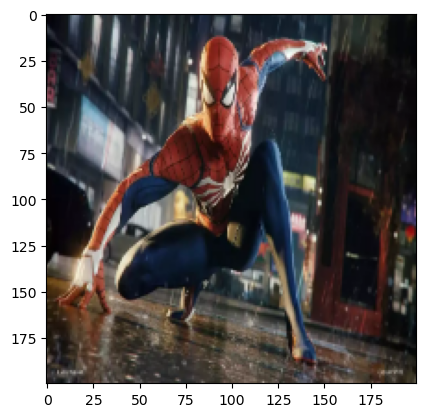

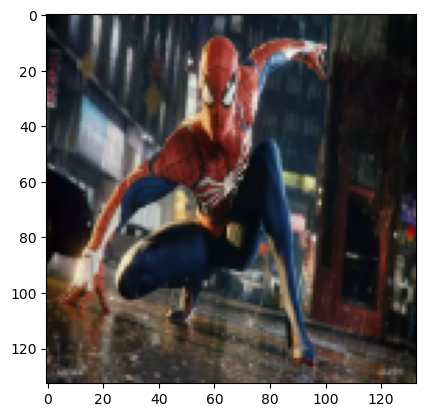

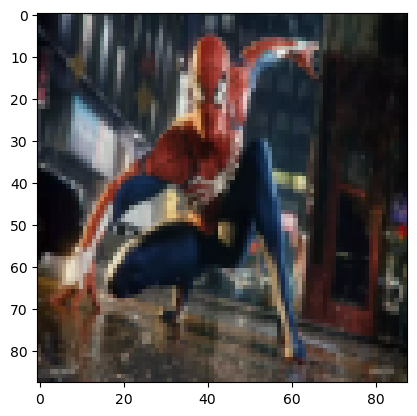

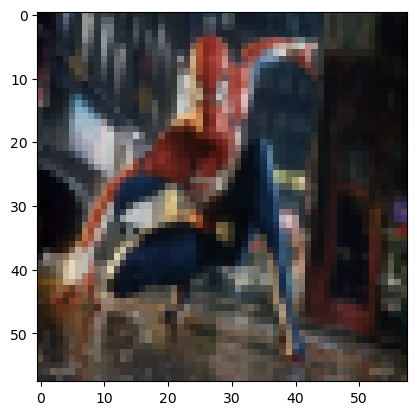

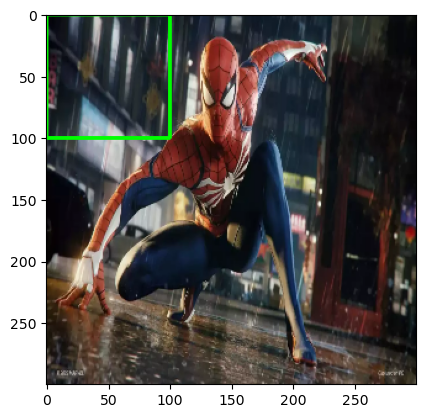

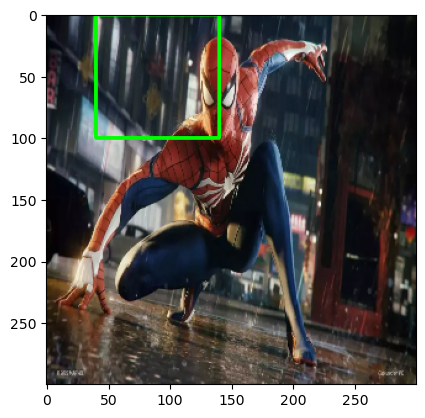

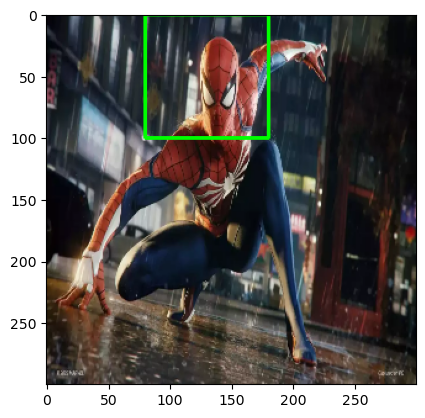

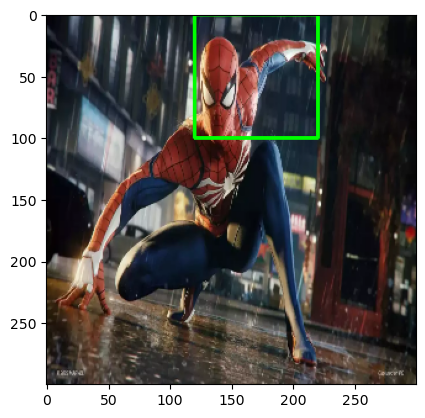

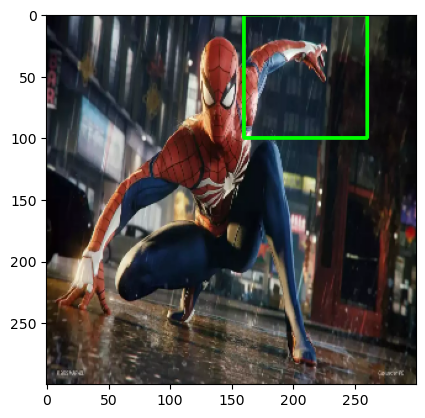

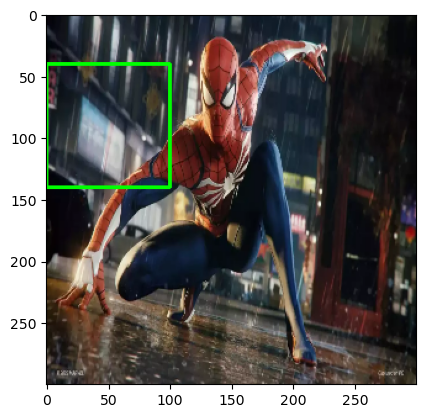

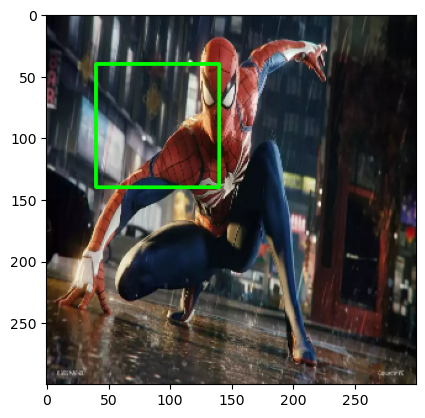

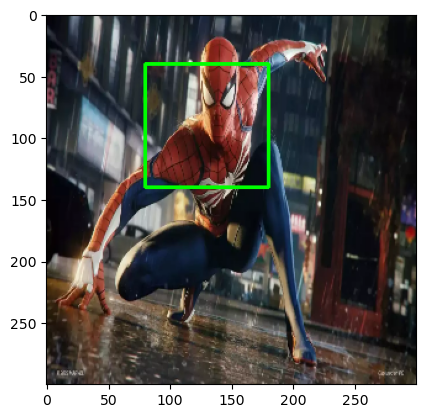

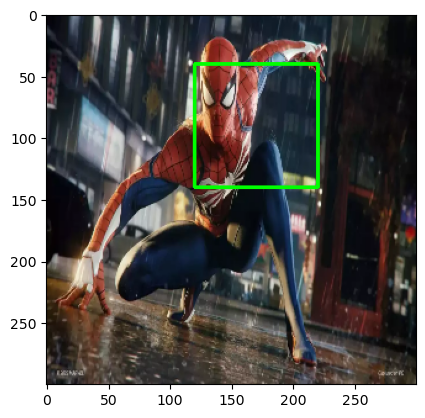

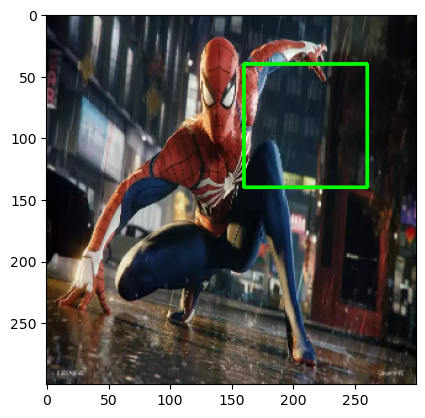

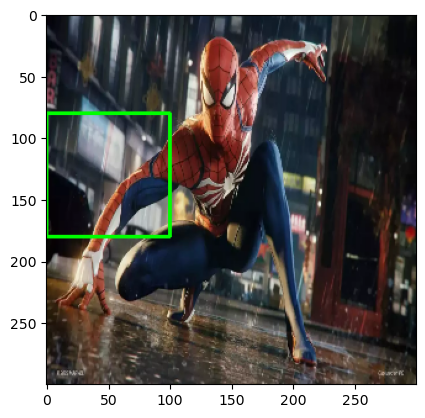

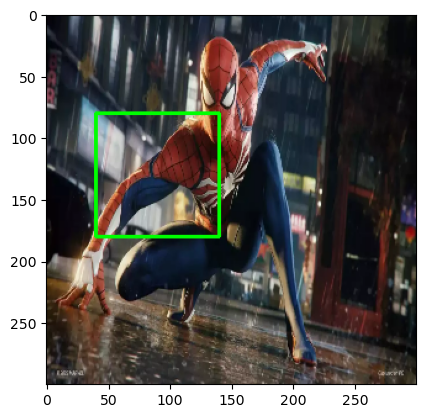

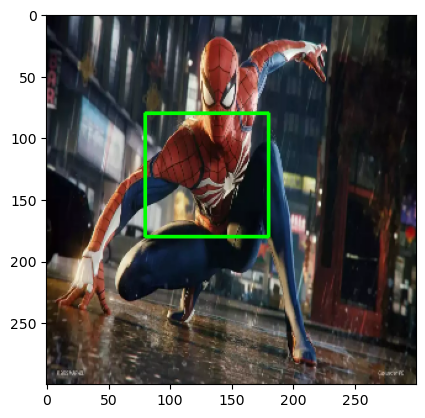

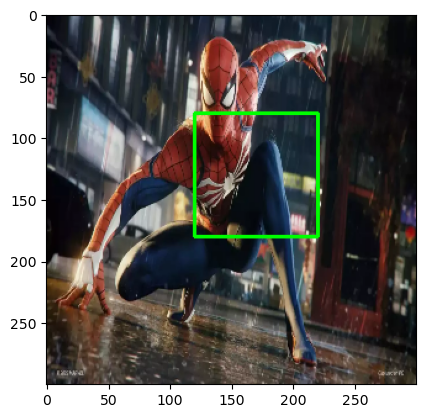

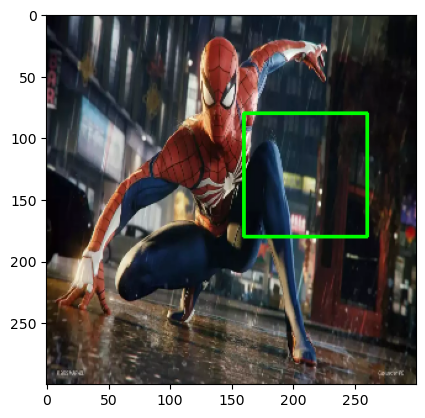

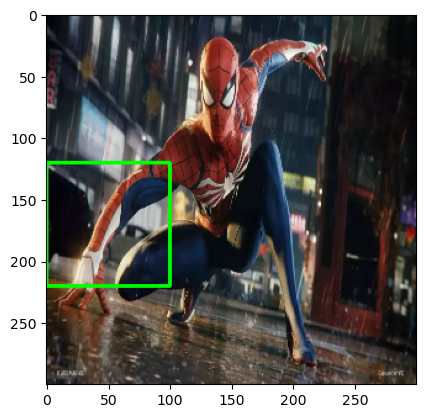

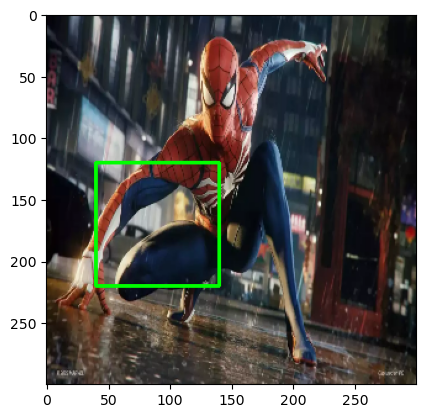

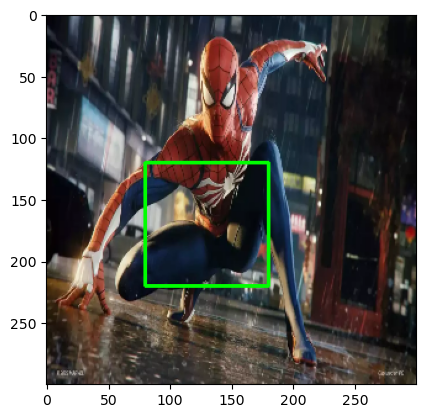

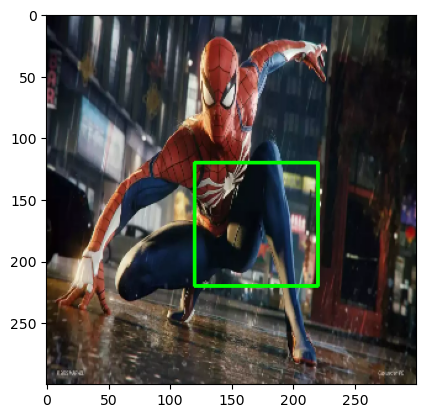

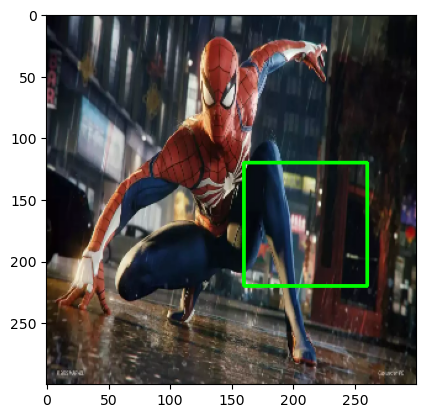

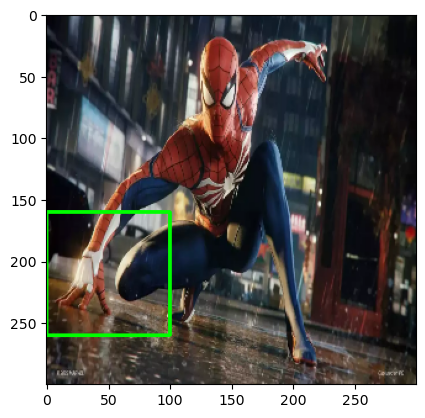

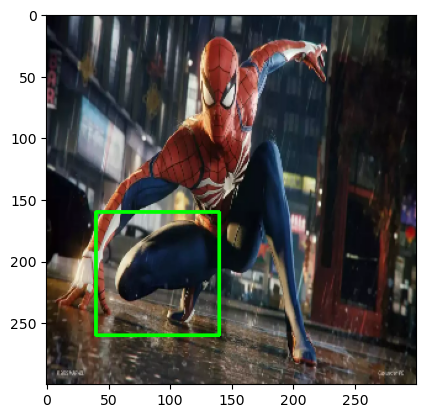

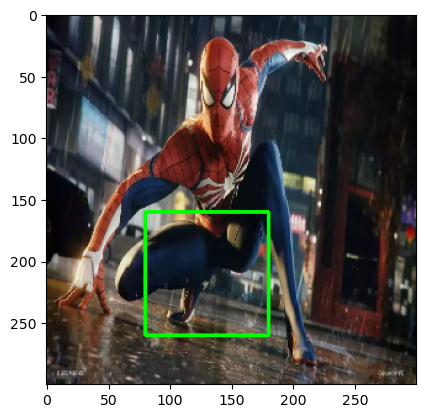

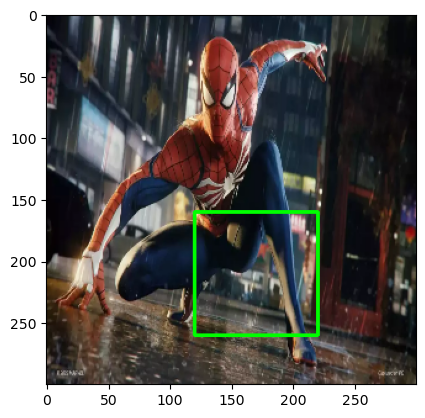

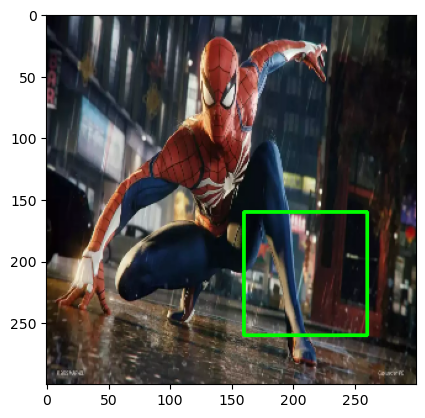

In [4]:
# Now we will check the functions by giving them a test image

img = cv2.imread("jpg.webp",1)
img = cv2.resize(img, (300,300))  

print("Our original image is ")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

for scaled_image in image_pyramid(img, 1.5, (50,50)):
    plt.figure()
    plt.imshow(scaled_image)

for x_val, y_val,_ in sliding_window(img, 40, (100,100)):
    img2 = img.copy()
    plt.figure()
    cv2.rectangle(img2, (x_val, y_val),(x_val + 100, y_val + 100),(0,255,0),2)
    plt.imshow(img2)

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import imutils
import time

In [44]:
# We will be using the ResNet for classifying the images
# Let us load the model
model = ResNet50(weights="imagenet", include_top=True)

# We will use picture of Rooster for object detection
# as it is one of the class in ImageNet dataset

img = cv2.imread("rooster.jpg")

# To ensure constant dimensions for all the images
# We will resize the image to a specified width
width = 300

img = cv2.resize(img, (width,width))


In [57]:
pyramid = image_pyramid(img, 1.5, (100,200))

# Now we will initialize two lists rois,locs to store Region of Interests and location of sliding window

rois = []
locs = []

for image in pyramid :
    scale = width/float(image.shape[1])
    
    # Now we will iterate through the sliding window
    step,size = 8,(200,250)
    for (x,y,roi) in sliding_window(image,step, size):
        # Scale the (x,y)-coordinates of the ROI with respect to the original image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(size[0] * scale)
        h = int(size[1] * scale)
        
        # Now we need to preprocess the ROI to classify the image
        
        roi = cv2.resize(roi, (224,224))
        roi = img_to_array(roi)
        roi = preprocess_input(roi)
       
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
        

rois = np.array(rois, dtype="float32")

In [58]:
# Time to make the predictions for the classification of ROI

preds = model.predict(rois)
preds = imagenet_utils.decode_predictions(preds, top=1) # This is done because we want only the top prediction for each ROI

# We will make a dictionary specifically for containing bounding boxes with class probability more than minimum
# probabilty  and the confidence scores and label.

labels = {}

3/3 [==============================] - 1s 476ms/step


2022-12-04 04:47:45.643737: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-04 04:47:45.644291: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [59]:
no_of_roi = len(rois)

min_prob = 0.7
for i in range(no_of_roi):
    (_,label,prob) = preds[i][0]
    
    if prob >= min_prob :
        
        labels[label] = (locs[i], prob)
        

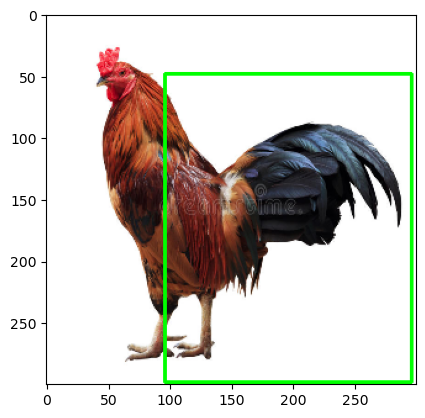

The label and the confidence scores are cock and 0.9556333422660828


In [61]:
# Time to apply Non-Maximum Suppression

final_roi = [p[0] for p in labels.values()]
scores = np.array([h[1] for h in labels.values()])

result = non_max_suppression(np.array(final_roi), scores)

# Now we just need to display the result
if len(result) == 0:
    print("No Object detected in the image")
for box in result:
    # draw the bounding box and label on the image
    clone = img.copy()
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
    plt.figure()
    clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
    plt.imshow(clone)
    plt.show()
    for cnt,box1 in enumerate(final_roi):
        if (box == box1).all():
            index = cnt
    lab, score = list(labels.keys())[index], scores[index]
    print("The label and the confidence scores are {} and {}".format(lab, score))

**Note that this model is highly sensitive to the size of ROI windows and a slight change in ROI window will completely change the predictions.**